In [1]:
import timeit
start = timeit.default_timer()

import os
os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'
import sys
print(sys.version)

3.10.9 (main, Mar  1 2023, 18:23:06) [GCC 11.2.0]


In [2]:
from datetime import datetime, timezone
import numpy as np
import pyarrow as pa
import geohash_tools as gh
import pyspark as ps

from PIL import Image
import requests

In [3]:
def f2k(f):
    return (f-32)*5/9+273.15

def k2f(k):
    return (k-273.15)*9/5+32

In [4]:
sp = spark.read.load('hdfs://orion11:14001/nam/2015/01/05/0000*',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

schema = sp.schema

sp = spark.read.schema(schema).load('hdfs://orion11:14001/nam/201*/*/*/*',
                     format='csv',
                     sep='\t',
                     header='true')
sp.printSchema()

root
 |-- 1_time: long (nullable = true)
 |-- 2_lat: double (nullable = true)
 |-- 3_lon: double (nullable = true)
 |-- albedo_surface: double (nullable = true)
 |-- precipitable_water_entire_atmosphere_single_layer: string (nullable = true)
 |-- pressure_maximum_wind: double (nullable = true)
 |-- pressure_surface: double (nullable = true)
 |-- pressure_tropopause: double (nullable = true)
 |-- relative_humidity_zerodegc_isotherm: double (nullable = true)
 |-- snow_depth_surface: double (nullable = true)
 |-- temperature_surface: double (nullable = true)
 |-- temperature_tropopause: double (nullable = true)
 |-- total_cloud_cover_entire_atmosphere_single_layer: string (nullable = true)
 |-- total_precipitation_surface_3_hour_accumulation: double (nullable = true)
 |-- vegetation_surface: double (nullable = true)
 |-- visibility_surface: double (nullable = true)
 |-- wilting_point_surface: double (nullable = true)
 |-- wind_speed_gust_surface: string (nullable = true)
 |-- _c18: string

In [5]:
sp = sp.select(['1_time','2_lat','3_lon','relative_humidity_zerodegc_isotherm',
                'temperature_surface','total_precipitation_surface_3_hour_accumulation'])

In [6]:
# Santa Cruz 36.9759239,-122.0681224
# Cedar City 37.6849692,-113.143335
# Freeport (Bahamas) 26.534748,-78.6855524
# Niagara Falls NY 43.099535,-79.029384
# Hill City South Dakota (Mn.Rushmore and Black Hills Forest) 43.9302167,-103.5894138

locs = np.array([
    [gh.encode(36.9759239,-122.0681224), 'Santa Cruz'],
    [gh.encode(37.6849692,-113.143335), 'Cedar City, UT'],
    [gh.encode(26.534748,-78.6855524), 'Freeport, Bahamas'],
    [gh.encode(43.099535,-79.029384), 'Niagara Falls'],
    [gh.encode(43.9302167,-103.5894138), 'Hill City, SD']
])

print(locs)

[['9q94q7' 'Santa Cruz']
 ['9qxw3k' 'Cedar City, UT']
 ['dk8ncq' 'Freeport, Bahamas']
 ['dpxv1w' 'Niagara Falls']
 ['9xy3fv' 'Hill City, SD']]


In [7]:
# set ideal conditions
temp_pref = 66 # F
hmdy_pref = 62 # %
prcp_pref =  0 # mm

# set relative deviation tolerance;
#    smaller number means more
#    sensitive to difference
temp_delta = 5 # F
hmdy_delta = 3 # %
prcp_delta = 2 # mm

temp_pref = f2k(temp_pref)
temp_delta = f2k(temp_delta)

In [8]:
# ( geohash, month, temp, humid, precip )
brdd = sp.rdd \
    .map(lambda x: ( gh.encode(x[1],x[2]),\
                     datetime.fromtimestamp(x[0]/1000, timezone.utc).month,\
                     x[4],x[3],x[5]*2 )) \
    .cache()

In [9]:
for i in range(locs.shape[0]):
    ghash = locs[i,0]
    locs[i,0] = brdd \
        .filter(lambda x: x[0].startswith(ghash[:1])) \
        .map(lambda x: ( gh.distance(x[0],ghash), x[0] )) \
        .reduce(lambda a,b: a if a[0] <= b[0] else b)[1]
print(locs)

[['971pnk' 'Santa Cruz']
 ['9ndnkk' 'Cedar City, UT']
 ['d7ncqd' 'Freeport, Bahamas']
 ['d55q4w' 'Niagara Falls']
 ['9eq6fy' 'Hill City, SD']]


In [10]:
def rms(e):
    return np.sqrt( np.square((e[0]-temp_pref)/temp_delta)+\
                    np.square((e[1]-hmdy_pref)/hmdy_delta)+\
                    np.square((e[2]-prcp_pref)/prcp_delta) )

# entries from respective geohash
# -> ( month ( temp, humid, precip, 1 ) )
# -> ( month ( sum_temps, sum_humids, sum_precips, sum_1's ) )
# -> ( avg_temp avg_humid avg_precip )

comfort_indeces = np.empty((0,12),dtype=np.float32)
for ghash in locs[:,0]:
    nar = np.array( brdd \
        .filter(lambda x: x[0] == ghash) \
        .map(lambda x: ( x[1],( x[2],x[3],x[4],1 ) )) \
        .reduceByKey(lambda a,b: ( a[0]+b[0],a[1]+b[1],a[2]+b[2],a[3]+b[3] )) \
        .map(lambda x: ( x[1][0]/x[1][3], x[1][1]/x[1][3], x[1][2]/x[1][3] )) \
        .map(lambda x: rms(x) ) \
        .collect(), dtype=np.float32)
    comfort_indeces = np.vstack((comfort_indeces, nar))

print(comfort_indeces)

[[10.750163   4.248264  11.727292  12.822936   7.95373   10.739607
   6.278193   2.9833524  6.0765877 12.77346   14.177692   8.005615 ]
 [ 3.8170674  4.5038595  1.6522794  0.5910301 12.763913   5.063552
  10.666696  15.898626   9.767725  10.506658   7.025283   2.925237 ]
 [18.117731  17.689684  17.83911   16.2167     6.5835276  3.7144635
  12.233444  10.478331   8.483514   1.2614597 14.60422   14.233546 ]
 [14.993887  15.313021  12.149471  14.550039  10.2500725  4.080096
   6.3834515  4.814803   1.8209224  8.378801   1.1959554 10.567091 ]
 [10.6078615 12.988535   6.262515  12.116729   3.56978    4.7359033
   5.836724   1.7888361  3.496918   1.3942034  2.932134  12.116706 ]]


In [11]:
month_map = ['January', 'February', 'March', 'April', 'May', 'June', 'July',\
             'August', 'September', 'October', 'November', 'December']

print('Based on your climate preferences,')
for i in range(locs.shape[0]):
    if i == locs.shape[0]-1:
        print('and',end=' ')
    print('the best time to visit', locs[i,1], 'is', month_map[comfort_indeces[i].argmin()],end=',\n\n')

Based on your climate preferences,
the best time to visit Santa Cruz is August,

the best time to visit Cedar City, UT is April,

the best time to visit Freeport, Bahamas is October,

the best time to visit Niagara Falls is November,

and the best time to visit Hill City, SD is October,



### Why Santa Cruz?

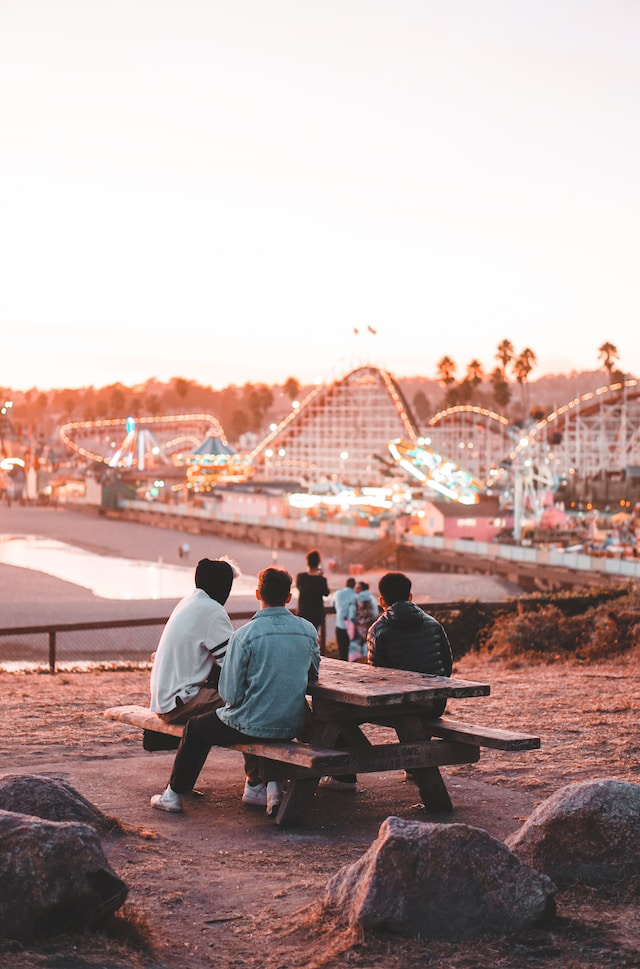

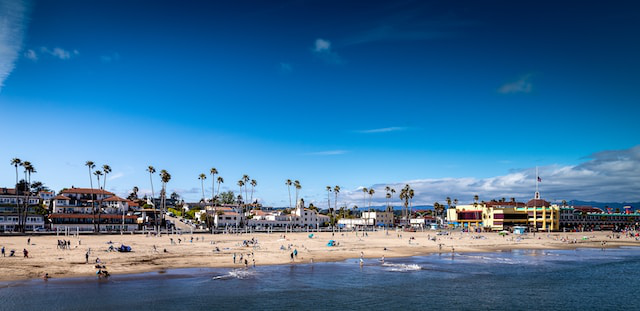

In [12]:
im1 = Image.open(requests.get('https://unsplash.com/photos/H_JFlYdHD5w/download?ixid=M3wxMjA3fDB8MXxzZWFyY2h8OHx8c2FudGElMjBjcnV6fGVufDB8fHx8MTY4NDY0MTUxMXww&force=true&w=640', stream=True).raw)
im2 = Image.open(requests.get('https://unsplash.com/photos/nCwBDLNq6Q8/download?ixid=M3wxMjA3fDB8MXxzZWFyY2h8MjB8fHNhbnRhJTIwY3J1enxlbnwwfHx8fDE2ODQ2NDE1MTF8MA&force=true&w=640', stream=True).raw)
im1.show()
im2.show()

### Why Cedar City?

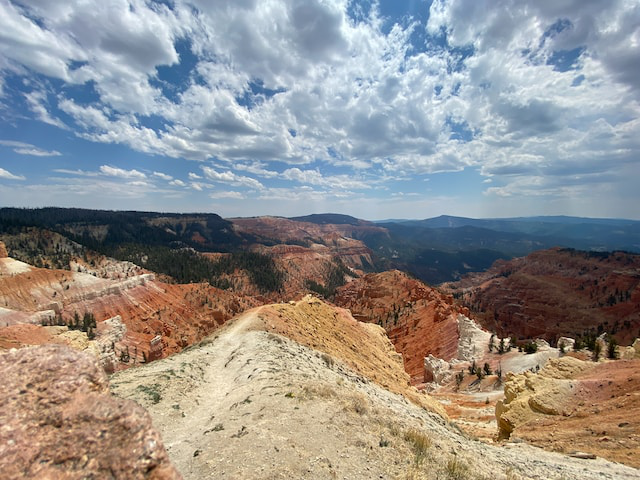

In [13]:
im1 = Image.open(requests.get('https://unsplash.com/photos/Qa-CMwq7OuU/download?ixid=M3wxMjA3fDB8MXxzZWFyY2h8MTF8fGNlZGFyJTIwY2l0eXxlbnwwfHx8fDE2ODQ2NjQ4NjJ8MA&force=true&w=640', stream=True).raw)
im1.show()

### Why Freeport?

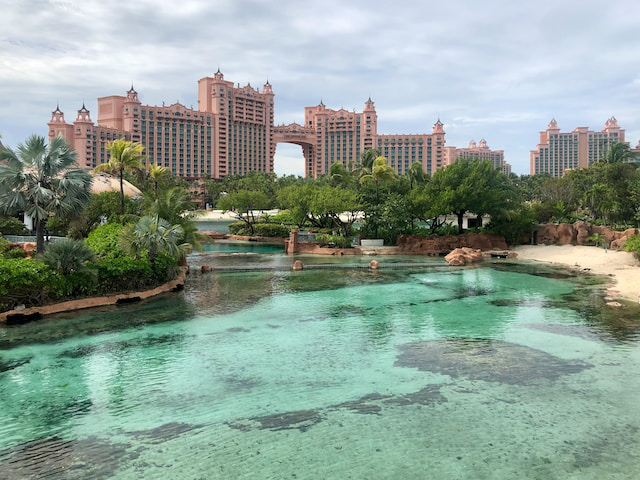

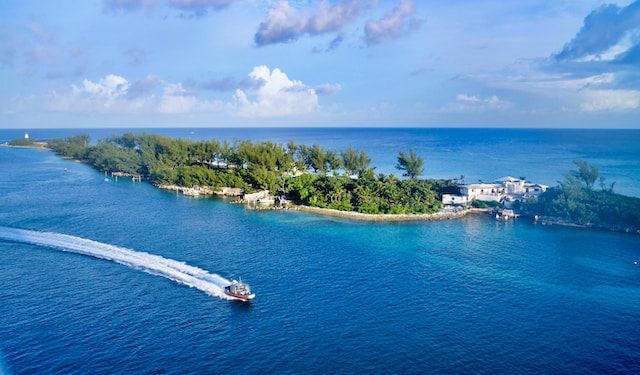

In [14]:
im1 = Image.open(requests.get('https://unsplash.com/photos/sNGImLlEZB8/download?ixid=M3wxMjA3fDB8MXxzZWFyY2h8MTZ8fGJhaGFtYXN8ZW58MHx8fHwxNjg0NjY0OTMxfDA&force=true&w=640', stream=True).raw)
im2 = Image.open(requests.get('https://unsplash.com/photos/WlP9h7kDRLo/download?ixid=M3wxMjA3fDB8MXxzZWFyY2h8MzN8fGJhaGFtYXN8ZW58MHx8fHwxNjg0NjY0OTQwfDA&force=true&w=640', stream=True).raw)
im1.show()
im2.show()

### Why Niagara Falls?

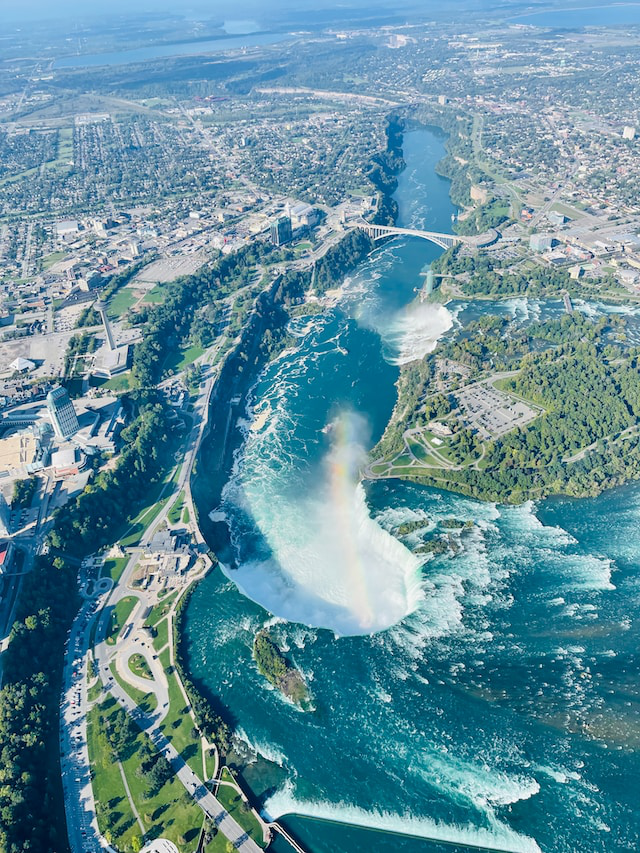

In [15]:
im1 = Image.open(requests.get('https://unsplash.com/photos/SwcZ8LqWmJw/download?ixid=M3wxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjg0NjY1MTgwfA&force=true&w=640', stream=True).raw)
im1.show()

### Why Hill City?

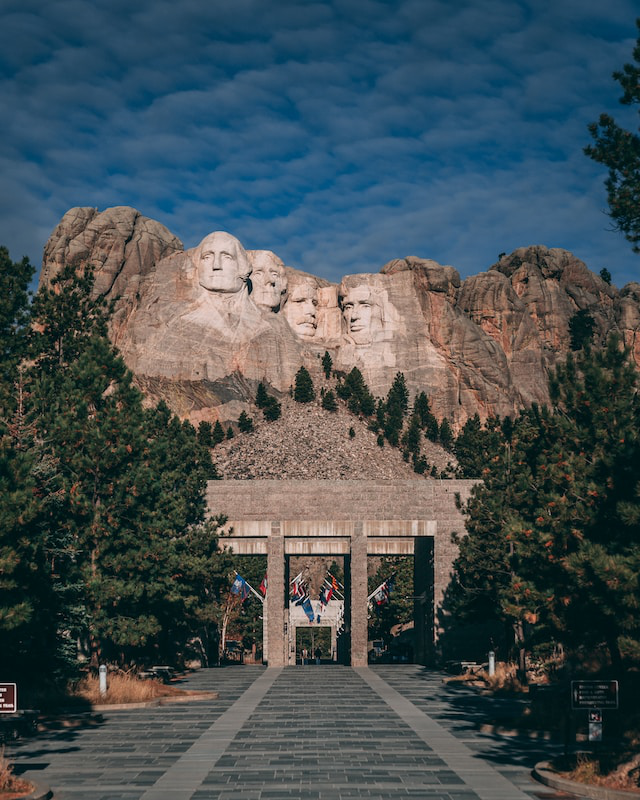

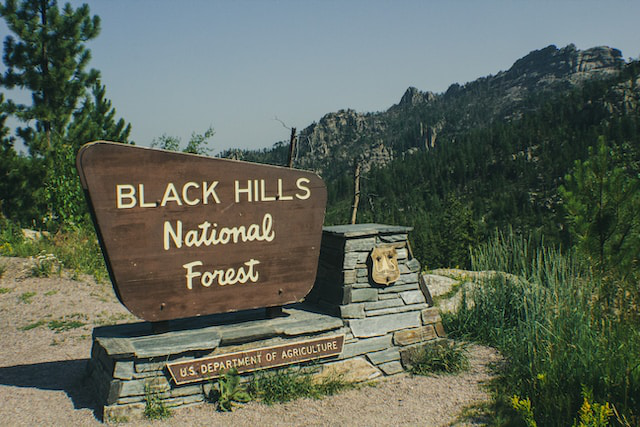

In [16]:
im1 = Image.open(requests.get('https://unsplash.com/photos/GyMIjpznBmY/download?ixid=M3wxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjg0NjY0MzYwfA&force=true&w=640', stream=True).raw)
im2 = Image.open(requests.get('https://unsplash.com/photos/WFm147nfU1k/download?ixid=M3wxMjA3fDB8MXxzZWFyY2h8MXx8YmxhY2slMjBoaWxscyUyMG5hdGlvbmFsJTIwZm9yZXN0fGVufDB8fHx8MTY4NDY2NDQ1MHww&force=true&w=640', stream=True).raw)
im1.show()
im2.show()

In [17]:
print(timeit.default_timer()-start)

525.2871301209088
